In [1]:
from diff_predictor import data_process, predxgboost, spatial
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt 

from os import listdir, getcwd, chdir
from os.path import isfile, join
import os
from sklearn.preprocessing import scale, StandardScaler
from numpy.random import permutation


from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, recall_score, precision_score, f1_score
import operator
import xgboost as xgb
import shap
from xgboost.training import CVPack
from xgboost import callback
from xgboost.core import CallbackEnv
from xgboost.core import EarlyStopException
from xgboost.core import STRING_TYPES

from sklearn.decomposition import PCA

# To use the experimental IterativeImputer, we need to explicitly ask for it:
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline


Using current directory for loading/saving: /Users/nelsschimek/Documents/Nance Lab/diff_predictor/notebooks/rotenone_notebooks
To change current directory, call diff_predictor.core.change_dir(...)


In [2]:
workbookDir = getcwd()

print('Current Notebook Dir: ' + workbookDir)
chdir(workbookDir) # Go to current workbook Dir"
chdir('..')        # Go up one
chdir('..')
print(f'Using current directory for loading data: {getcwd()}')
workbookDir = getcwd()

Current Notebook Dir: /Users/nelsschimek/Documents/Nance Lab/diff_predictor/notebooks/rotenone_notebooks
Using current directory for loading data: /Users/nelsschimek/Documents/Nance Lab/diff_predictor


In [3]:
#load paths to data
cortex_10day_feature_path = workbookDir + '/data/Brendan_traj_data/Cortex_features/'
cortex_10day_feature_filelist = [f for f in listdir(cortex_10day_feature_path) if isfile(join(cortex_10day_feature_path, f)) and '10DIV' in f]
print((cortex_10day_feature_filelist))

cortex_7day_feature_path = workbookDir + '/data/Brendan_traj_data/Cortex_features/'
cortex_7day_feature_filelist = [f for f in listdir(cortex_7day_feature_path) if isfile(join(cortex_7day_feature_path, f)) and '7DIV' in f]
print((cortex_7day_feature_filelist))

['features_P10F_10uM_10DIV_40nm_slice_2_cortex_vid_1.csv', 'features_P10F_NT_10DIV_40nm_slice_1_cortex_vid_2.csv', 'features_P10F_NT_10DIV_40nm_slice_1_cortex_vid_1.csv', 'features_P10F_50nM_10DIV_40nm_slice_1_cortex_vid_1.csv', 'features_P10F_1uM_10DIV_40nm_slice_1_cortex_vid_1.csv', 'features_P10F_5uM_10DIV_40nm_slice_1_cortex_vid_2.csv', 'features_P10F_10uM_10DIV_40nm_slice_1_cortex_vid_1.csv']
['features_P10F_5uM_7DIV_40nm_slice_1_cortex_vid_1.csv', 'features_P10F_NT_7DIV_40nm_slice_1_cortex_vid_1.csv', 'features_P10F_NT_7DIV_40nm_slice_1_cortex_vid_2.csv', 'features_P10F_1uM_7DIV_40nm_slice_1_cortex_vid_1.csv', 'features_P10F_5uM_7DIV_40nm_slice_2_cortex_vid_2.csv', 'features_P10F_1uM_7DIV_40nm_slice_1_cortex_vid_2.csv', 'features_P10F_50nM_7DIV_40nm_slice_1_cortex_vid_1.csv']


In [4]:
fstats_cortex_10day = data_process.generate_fullstats(cortex_10day_feature_path, cortex_10day_feature_filelist, ['NT', '10uM'], 'dosage')
fstats_cortex_7day = data_process.generate_fullstats(cortex_7day_feature_path, cortex_7day_feature_filelist, ['NT', '1uM', '5uM'], 'dosage')

Adding file features_P10F_10uM_10DIV_40nm_slice_2_cortex_vid_1.csv size: (2460, 68)
Adding file features_P10F_NT_10DIV_40nm_slice_1_cortex_vid_2.csv size: (1351, 68)
Adding file features_P10F_NT_10DIV_40nm_slice_1_cortex_vid_1.csv size: (1533, 68)
Adding file features_P10F_10uM_10DIV_40nm_slice_1_cortex_vid_1.csv size: (957, 68)
Adding file features_P10F_5uM_7DIV_40nm_slice_1_cortex_vid_1.csv size: (2405, 68)
Adding file features_P10F_NT_7DIV_40nm_slice_1_cortex_vid_1.csv size: (1738, 68)
Adding file features_P10F_NT_7DIV_40nm_slice_1_cortex_vid_2.csv size: (1190, 68)
Adding file features_P10F_1uM_7DIV_40nm_slice_1_cortex_vid_1.csv size: (638, 68)
Adding file features_P10F_5uM_7DIV_40nm_slice_2_cortex_vid_2.csv size: (2829, 68)
Adding file features_P10F_1uM_7DIV_40nm_slice_1_cortex_vid_2.csv size: (863, 68)


In [5]:
feature_list = [
    'alpha', # Fitted anomalous diffusion alpha exponenet
    'D_fit', # Fitted anomalous diffusion coefficient
    'kurtosis', # Kurtosis of track
    'asymmetry1', # Asymmetry of trajecory (0 for circular symmetric, 1 for linear)
    'asymmetry2', # Ratio of the smaller to larger principal radius of gyration
    'asymmetry3', # An asymmetric feature that accnts for non-cylindrically symmetric pt distributions
    'AR', # Aspect ratio of long and short side of trajectory's minimum bounding rectangle
    'elongation', # Est. of amount of extension of trajectory from centroid
    'boundedness', # How much a particle with Deff is restricted by a circular confinement of radius r
    'fractal_dim', # Measure of how complicated a self similar figure is
    'trappedness', # Probability that a particle with Deff is trapped in a region
    'efficiency', # Ratio of squared net displacement to the sum of squared step lengths
    'straightness', # Ratio of net displacement to the sum of squared step lengths
    'MSD_ratio', # MSD ratio of the track
#     'frames', # Number of frames the track spans
    'Deff1', # Effective diffusion coefficient at 0.33 s
    'Deff2', # Effective diffusion coefficient at 3.3 s
    #'angle_mean', # Mean turning angle which is counterclockwise angle from one frame point to another
    #'angle_mag_mean', # Magnitude of the turning angle mean
    #'angle_var', # Variance of the turning angle
    #'dist_tot', # Total distance of the trajectory
    #'dist_net', # Net distance from first point to last point
    #'progression', # Ratio of the net distance traveled and the total distance
    'Mean alpha', 
    'Mean D_fit', 
    'Mean kurtosis', 
    'Mean asymmetry1', 
    'Mean asymmetry2',
    'Mean asymmetry3', 
    'Mean AR',
    'Mean elongation', 
    'Mean boundedness',
    'Mean fractal_dim', 
    'Mean trappedness', 
    'Mean efficiency',
    'Mean straightness', 
    'Mean MSD_ratio', 
    'Mean Deff1', 
    'Mean Deff2',
    ]

target = 'dosage'

In [6]:
ecm_10day = fstats_cortex_10day[feature_list + [target, 'Track_ID', 'X', 'Y']] #dont think i need these rn
print(ecm_10day.shape)
ecm_10day = ecm_10day[~ecm_10day[list(set(feature_list) - set(['Deff2', 'Mean Deff2']))].isin([np.nan, np.inf, -np.inf]).any(1)]       # Removing nan and inf data points
print(ecm_10day.shape)

ecm_7day = fstats_cortex_7day[feature_list + [target, 'Track_ID', 'X', 'Y']] #dont think i need these rn
print(ecm_7day.shape)
ecm_7day = ecm_7day[~ecm_7day[list(set(feature_list) - set(['Deff2', 'Mean Deff2']))].isin([np.nan, np.inf, -np.inf]).any(1)]       # Removing nan and inf data points
print(ecm_7day.shape)

(6301, 36)
(5934, 36)
(9663, 36)
(8625, 36)


In [7]:
ecm.isna().sum()

NameError: name 'ecm' is not defined

In [8]:
bal_ecm_10day = data_process.balance_data(ecm_10day, target, random_state=1)
bal_ecm_10day = data_process.bin_data(bal_ecm_10day, resolution=128)

bal_ecm_7day = data_process.balance_data(ecm_7day, target, random_state=1)
bal_ecm_7day = data_process.bin_data(bal_ecm_7day, resolution=128)

Ratio before data balance (10uM:NT) = 3257:2677
Ratio after balance (10uM:NT) = 2677:2677
Ratio before data balance (5uM:NT:1uM) = 4577:2759:1289
Ratio after balance (5uM:NT:1uM) = 1289:1289:1289


In [9]:
labels_10day = np.array(bal_ecm_10day['dosage'])
features_df_10day = bal_ecm_10day.drop(['dosage', 'X', 'Y', 'Track_ID'], axis=1)
col_names = features_df_10day.columns

labels_7day = np.array(bal_ecm_7day['dosage'])
features_df_7day = bal_ecm_7day.drop(['dosage', 'X', 'Y', 'Track_ID'], axis=1)
col_names = features_df_7day.columns

In [10]:
scaler = StandardScaler()
scaled_df_10day = scaler.fit_transform(features_df_10day)
scaled_df_10day = pd.DataFrame(scaled_df_10day, columns=col_names)
scaled_df_10day = scaled_df_10day.fillna(0)

In [11]:
scaler = StandardScaler()
scaled_df_7day = scaler.fit_transform(features_df_7day)
scaled_df_7day = pd.DataFrame(scaled_df_7day, columns=col_names)
scaled_df_7day = scaled_df_7day.fillna(0)

In [19]:
pca = PCA(n_components=10).fit(scaled_df_10day)
print(pca.explained_variance_ratio_.sum())
pca_embeddings = pca.transform(scaled_df_10day)
pca_embeddings_df = pd.DataFrame(pca_embeddings[:, :2], columns=['Component 1', 'Component 2'])
pca_embeddings_df['target'] = labels_10day

0.788514523946376


In [21]:
pca = PCA(n_components=10).fit(scaled_df_7day)
print(pca.explained_variance_ratio_.sum())
pca_embeddings = pca.transform(scaled_df_7day)
pca_embeddings_df = pd.DataFrame(pca_embeddings[:, :2], columns=['Component 1', 'Component 2'])
pca_embeddings_df['target'] = labels_7day

0.7955705472198196


(array([-15., -10.,  -5.,   0.,   5.,  10.,  15.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

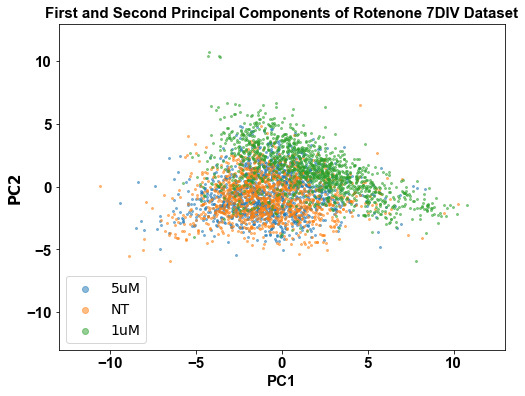

In [22]:
##colors = {'NT': '#56B4E9', '10uM': '#009E73'}# :'P14': '#E69F00', 'P21': '#7b3294', 'P28': '#d7191c'}

fig, ax = plt.subplots(figsize=(8,6))
for uclass in pca_embeddings_df['target'].unique():
    df = pca_embeddings_df[pca_embeddings_df['target'] == uclass]#.sample(500)
    x = df['Component 1']
    y = df['Component 2']
    plt.scatter(x,y, alpha=0.5, s=4, label=uclass)#, #c=colors[uclass])
plt.legend(loc='lower left', markerscale=3, fontsize=14)
plt.xlim([-13,13])
plt.ylim([-13,13])
plt.xlabel('PC1', fontname='Arial', fontsize=15, fontweight='bold')
plt.ylabel('PC2', fontsize=15, fontweight='bold')
plt.title('First and Second Principal Components of Rotenone 7DIV Dataset', fontname='Arial', fontsize=15, fontweight='bold')
plt.xticks(fontsize=15, fontname='Arial', fontweight='bold')
plt.yticks(fontsize=15, fontname='Arial', fontweight='bold')

In [24]:
def full_preprocess(ecm, balanced=True, y_scramble=False, target=None):

    rand_state = np.random.randint(1, 2000)
    if balanced:
        bal_ecm = data_process.balance_data(ecm, target, random_state=rand_state)
        bal_ecm = bal_ecm.reset_index(drop=True)
        #sampled_df = bal_ecm.sample(frac=0.5)
        sampled_df = data_process.bin_data(bal_ecm)
    else:
        sampled_df = data_process.bin_data(ecm)
    label_df = sampled_df[target]
    features_df = sampled_df.drop([target, 'X', 'Y', 'binx', 'biny', 'bins', 'Track_ID'], axis=1)
    features = features_df.columns

    if y_scramble:
        perm = permutation(len(label_df))
        label_shuffled = label_df[perm]
        le = preprocessing.LabelEncoder()
        sampled_df['encoded_target'] = le.fit_transform(label_shuffled)
    else:
        le = preprocessing.LabelEncoder()
        sampled_df['encoded_target'] = le.fit_transform(sampled_df[target])

    seed = rand_state
    np.random.seed(seed)
    train_split = 0.8
    test_split = 0.5


    training_bins = np.random.choice(sampled_df['bins'].unique(), int(len(sampled_df['bins'].unique())*train_split), replace=False)

    X_train = sampled_df[sampled_df['bins'].isin(training_bins)]
    X_test_val = sampled_df[~sampled_df['bins'].isin(training_bins)]
    X_val, X_test = train_test_split(X_test_val, test_size=test_split, random_state=seed)

    y_train = X_train['encoded_target']
    y_test = X_test['encoded_target']
    y_val = X_val['encoded_target']

    dtrain = xgb.DMatrix(X_train[features], label=y_train)
    dtest = xgb.DMatrix(X_test[features], label=y_test)
    dval = xgb.DMatrix(X_val[features], label=y_val)
    return dtrain, dtest, dval, X_train, X_test, y_train, y_test, le



In [28]:
dtrain, dtest, dval, X_train, X_test, y_train, y_test, le = full_preprocess(ecm_10day, True, False, 'dosage')

Ratio before data balance (10uM:NT) = 3257:2677
Ratio after balance (10uM:NT) = 2677:2677


In [29]:
param = {'max_depth': 3,
         'eta': 0.005,
         'min_child_weight': 0,
         'verbosity': 0,
         'objective': 'multi:softprob',
         'num_class': 3,
         'silent': 'True',
         'gamma': 5,
         'subsample': 0.15,
         'colsample_bytree': 0.8,
         'eval_metric': "mlogloss",
#          # GPU integration will cut time in ~half:
#          'gpu_id' : 0,
#          'tree_method': 'gpu_hist',
#          'predictor': 'gpu_predictor'
         }

In [30]:
booster, acc, true_label, preds = predxgboost.train(param, dtrain, dtest, dval, evals=[(dtrain, 'train'), (dval, 'eval')], num_round=200, verbose=False)

Accuracy: 0.726530612244898


In [35]:
def get_dropna_scores(ecm, target, boost_rounds=200):
    ecm = ecm.dropna()
    dtrain, dtest, dval, X_train, X_test, y_train, y_test, le = full_preprocess(ecm, True, False, target)
    booster, acc, true_label, preds = predxgboost.train(param, dtrain, dtest, dval, evals=[(dtrain, 'train'), (dval, 'eval')], num_round=boost_rounds, verbose=False)
    return acc

In [36]:
def get_fillna_scores(ecm, target, boost_rounds=200, fillna_value=0):
    ecm = ecm.fillna(fillna_value)
    dtrain, dtest, dval, X_train, X_test, y_train, y_test, le = full_preprocess(ecm, True, False, target)
    booster, acc, true_label, preds = predxgboost.train(param, dtrain, dtest, dval, evals=[(dtrain, 'train'), (dval, 'eval')], num_round=boost_rounds, verbose=False)
    print(f'accuracy is {acc}')
    return acc

In [37]:
def get_impute_knn_scores(ecm, target, boost_rounds):
    imputer = KNNImputer()
    impute_vals = imputer.fit_transform(ecm[feature_list])
    imputed_df = pd.DataFrame(data=impute_vals, columns=feature_list)
    imputed_df['dosage'] = ecm['dosage'].values
    imputed_df['X'] = ecm['X'].values
    imputed_df['Y'] = ecm['Y'].values
    imputed_df['Track_ID'] = ecm['Track_ID'].values 
    dtrain, dtest, dval, X_train, X_test, y_train, y_test, le = full_preprocess(imputed_df, True, False, target)
    booster, acc, true_label, preds = predxgboost.train(param, dtrain, dtest, dval, evals=[(dtrain, 'train'), (dval, 'eval')], num_round=boost_rounds, verbose=False)
    return acc

In [38]:
def get_impute_iterative_scores(ecm, target, boost_rounds):
    imputer = IterativeImputer()
    impute_vals = imputer.fit_transform(ecm[feature_list])
    imputed_df = pd.DataFrame(data=impute_vals, columns=feature_list)
    imputed_df['dosage'] = ecm['dosage'].values
    imputed_df['X'] = ecm['X'].values
    imputed_df['Y'] = ecm['Y'].values
    imputed_df['Track_ID'] = ecm['Track_ID'].values 
    dtrain, dtest, dval, X_train, X_test, y_train, y_test, le = full_preprocess(imputed_df, True, False, target)
    booster, acc, true_label, preds = predxgboost.train(param, dtrain, dtest, dval, evals=[(dtrain, 'train'), (dval, 'eval')], num_round=boost_rounds, verbose=False)
    return acc

In [31]:
num_iters = 10

normal_acc = np.zeros(num_iters)
fillna_acc = np.zeros(num_iters)
dropna_acc = np.zeros(num_iters)
impute_knn_acc= np.zeros(num_iters)
impute_iterative_acc = np.zeros(num_iters)

for i in range(num_iters):
    dtrain, dtest, dval, X_train, X_test, y_train, y_test, le = full_preprocess(ecm_7day, True, False, target)
    booster, acc, true_label, preds = predxgboost.train(param, dtrain, dtest, dval, evals=[(dtrain, 'train'), (dval, 'eval')], num_round=200, verbose=False)
    normal_acc[i] = acc
    fillna_acc[i] = get_fillna_scores(ecm_7day, 'dosage', 1000, 0)
    dropna_acc[i] = get_dropna_scores(ecm_7day, 'dosage', 200)
    impute_knn_acc[i] = get_impute_knn_scores(ecm_7day, 'dosage', 1000)
    impute_iterative_acc[i] = get_impute_iterative_scores(ecm_7day, 'dosage', 200)

Ratio before data balance (5uM:NT:1uM) = 4577:2759:1289
Ratio after balance (5uM:NT:1uM) = 1289:1289:1289
Accuracy: 0.6077922077922078


NameError: name 'get_fillna_scores' is not defined

In [122]:
fillna_acc

array([0.60037175, 0.70127119, 0.66979362, 0.7556391 , 0.71481481,
       0.74048443, 0.67725753, 0.73443223, 0.61209964, 0.74269006,
       0.72743056, 0.72637795, 0.621881  , 0.68849206, 0.57420495,
       0.76521739, 0.73320896, 0.72293578, 0.63500931, 0.621881  ,
       0.68849206, 0.57420495, 0.76521739, 0.73320896, 0.72293578])

In [43]:
print(normal_acc.mean())
print(fillna_acc.mean())
print(dropna_acc.mean())
print(impute_knn_acc.mean())
print(impute_iterative_acc.mean())

0.6239884531042079
0.6079955663050601
0.574286215634245
0.6073162898764508
0.6212131727267682
